## Training Notebook

Define and train an RNN in Tensorflow.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import hashlib

from tensorflow import set_random_seed

# Set random seeds for reproducible results
np.random.seed(42)
set_random_seed(42)

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# Rough proportion of data in training set
train_split = 0.7
# Max character length of a message, hardcoded in OSRS as 80 chars
max_chars = 80
# Threshold above which a message is classed as spam
spam_thresh = 0.50

# Get rid of pandas warning
pd.options.mode.chained_assignment = None

tf.__version__

'1.13.0-rc2'

In [3]:
# Load and deduplicate the dataset

df = pd.read_csv("dataset.csv", index_col=0)
df = df.drop_duplicates('message').reset_index()

In [4]:
# Split the dataset by user, using MD5 hash to make splitting deterministic and repeatable after adding new data
# The split proportion won't be exactly as specified, but it'll be good enough

split_val = (2 ** 128 - 1) * train_split
df['usermd5'] = [int(hashlib.md5(user.encode("utf-8")).hexdigest(), 16) for user in df['user']]
traindf = df[df['usermd5'] < split_val]
testdf = df[df['usermd5'] > split_val]

# Messages are short enough that we probably don't need to tokenize by words
# Instead, just encode them as a list of ints using utf-8 encoding and use that as the input sequence

seqs = pad_sequences([list(msg.encode('utf-8')) for msg in np.array(df['message'])], maxlen=max_chars)
seqs = seqs.reshape((len(seqs), max_chars, 1))

msg_train = traindf['message']
msg_test = testdf['message']

X_train = seqs[traindf.index]
X_test = seqs[testdf.index]

Y_train = np.array(traindf['spam'])
Y_test = np.array(testdf['spam'])

print("Proportion of data in train set: {}".format(len(X_train) / (len(X_train) + len(X_test))))
print("Proportion of data in test set: {}".format(len(X_test) / (len(X_train) + len(X_test))))

Proportion of data in train set: 0.7197990688556726
Proportion of data in test set: 0.28020093114432737


In [5]:
# Define Keras model
# Model archetecture:
# Input layer of length 80
# Hidden LSTM layer with 100 units
# Output layer, FC with sigmoid activation

inputs = Input(shape=(80,1))
X = LSTM(50)(inputs)
output = Dense(1, activation='sigmoid')(X)
model = Model(inputs=inputs, outputs=output)

display(model.summary())

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


None

In [6]:
# Train the model, checking performance on validation set. 
# Model tends to converge before around 25 epochs with batch size of 128.
# Training takes about 1 minute on an i3.

history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_test, Y_test), batch_size=128, verbose=2)

K.set_learning_phase(0)

Instructions for updating:
Use tf.cast instead.


Train on 5875 samples, validate on 2287 samples
Epoch 1/25
 - 6s - loss: 0.3201 - acc: 0.8466 - val_loss: 0.1529 - val_acc: 0.9331
Epoch 2/25
 - 3s - loss: 0.1976 - acc: 0.9256 - val_loss: 0.1171 - val_acc: 0.9598
Epoch 3/25
 - 4s - loss: 0.1383 - acc: 0.9619 - val_loss: 0.0866 - val_acc: 0.9690
Epoch 4/25
 - 3s - loss: 0.1125 - acc: 0.9675 - val_loss: 0.0723 - val_acc: 0.9768
Epoch 5/25
 - 3s - loss: 0.1000 - acc: 0.9695 - val_loss: 0.0552 - val_acc: 0.9851
Epoch 6/25
 - 4s - loss: 0.0905 - acc: 0.9743 - val_loss: 0.0545 - val_acc: 0.9847
Epoch 7/25
 - 4s - loss: 0.0821 - acc: 0.9758 - val_loss: 0.0518 - val_acc: 0.9873
Epoch 8/25
 - 4s - loss: 0.0781 - acc: 0.9779 - val_loss: 0.0449 - val_acc: 0.9899
Epoch 9/25
 - 4s - loss: 0.0721 - acc: 0.9797 - val_loss: 0.0413 - val_acc: 0.9895
Epoch 10/25
 - 4s - loss: 0.0693 - acc: 0.9799 - val_loss: 0.0420 - val_acc: 0.9899
Epoch 11/25
 - 4s - loss: 0.0651 - acc: 0.9813 - val_loss: 0.0381 - val_acc: 0.9899
Epoch 12/25
 - 4s - loss: 0.0635 - ac

In [ ]:
sns.lineplot(
    data=pd.DataFrame({'Train Loss': history.history['loss'], 'Val Loss': history.history['val_loss']})
).set_title('Loss')
plt.show()
sns.lineplot(
    data=pd.DataFrame({'Train Acc': history.history['acc'], 'Val Acc': history.history['val_acc']})
).set_title('Accuracy')
plt.show()

In [ ]:
# Make predictions on entire dataset and re-split into test and train sets

allpreds = model.predict(seqs)
df['pred'] = allpreds
df['predclass'] = allpreds > spam_thresh
testdf = df.iloc[testdf.index]
traindf = df.iloc[traindf.index]

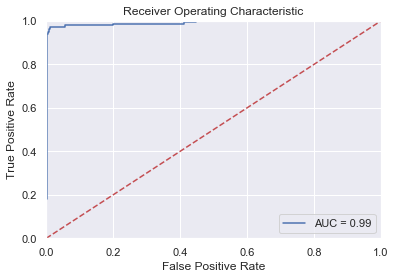

In [21]:
fpr, tpr, threshold = roc_curve(Y_test, testdf['pred'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#display(pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': threshold}))

Text(0.5, 1.0, 'Test set confusion matrix')

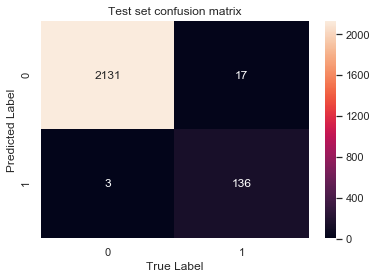

In [22]:
# Test set confusion matrix and misclassified examples

conf = confusion_matrix(testdf['predclass'], testdf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='d')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Test set confusion matrix")

Text(0.5, 1.0, 'Train set confusion matrix')

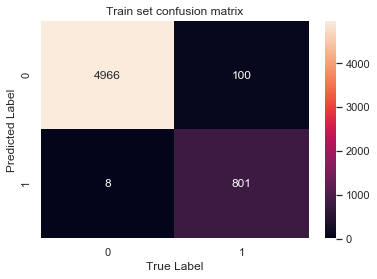

In [23]:
# Training set confusion matrix and misclassified examples

conf = confusion_matrix(traindf['predclass'], traindf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Train set confusion matrix")

In [24]:
# Show misclassified test and train samples

display(testdf[testdf['spam'] != testdf['predclass']])
display(traindf[traindf['spam'] != traindf['predclass']])

,index,user,message,spam,usermd5,pred,predclass
695,1057,Dr Badboi,"""Dicing Osrs"" Cc | Dice Game & Trusted Ranks ...",True,286095820816676094397995391855115745271,0.227636,False
879,1683,Dr Badboi,"""Dicing Osrs"" Cc | Dice Game & Trusted Ranks ...",True,286095820816676094397995391855115745271,0.356247,False
979,2005,drops baby,3Bill Drop Party world 337 Varrock Big Bank (...,False,291923433044304631138471059209565866351,0.842303,True
999,2065,RNG 2406,Dr Respect has won [300K] with a roll of [78]!,True,279181617210965328225226786640173288696,0.094628,False
1669,3280,Balidom,"""Gold Rollers"" Cc | Dice Game & Trusted Ranks...",True,330510892855630722895942706708750606703,0.242781,False
1706,3372,Balidom,"""Gold Rollers"" Cc | Dice Game & Trusted Ranks...",True,330510892855630722895942706708750606703,0.367484,False
4750,9871,SD5F18W9E1F,12,True,329909298706440773297071059533164461445,0.000929,False
4862,10085,tghty,22222222222222222222222,True,257205153845717120453435852529780083546,0.136207,False
5193,10913,Rolls Bawls,Double 1-15m 1t rade--rolls--,True,254548825097137409634313310951043463812,0.062863,False
5196,10923,Rolls Bawls,Double 1-15m 1 trade--rolls--,True,254548825097137409634313310951043463812,0.064974,False


,index,user,message,spam,usermd5,pred,predclass
18,24,ergdfgerdfge,"R S M A L L S, Cih 0M Se11 G01d & Acc 1000...",True,31099183701523936513726640624730960647,0.224585,False
25,31,cgva,/-/R u n e c h a t/*/* b e s t ---and legit -*...,True,28658148026408713154586770929645878555,0.051986,False
47,61,cgva,*-*R u n e c h a t !@!@!@ c 0 m //bet g p for ...,True,28658148026408713154586770929645878555,0.355246,False
97,140,Msakelueuce,Sr Swap !,True,118060575076076955316859972846010363839,0.009216,False
111,157,Msakelueuce,Sr Swap !,True,118060575076076955316859972846010363839,0.000833,False
150,208,Ix2YourStack,Doubling Cash~!~!,True,193995738432610091110469746641694197895,0.011009,False
226,319,Ix2YourStack,50K Taken~!~!,True,193995738432610091110469746641694197895,0.016347,False
232,332,Ix2YourStack,100K Given~!~!,True,193995738432610091110469746641694197895,0.028654,False
371,560,RNG 2403,Blunt Joints has won [600K] with a roll of [87]!,True,178422893969001506663590303374955638795,0.096834,False
372,561,Ix2YourStack,Doubling Cash~!~!,True,193995738432610091110469746641694197895,0.013639,False


In [12]:
# Test cumulative spamminess of a user

users = {}
spampred = []

for idx, row in testdf.iterrows():
    prior, num = users.get(row['user'], (0.10, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
testdf['cumulativespam'] = spampred

In [13]:
testdf[testdf['spam'] != testdf['cumulativespam']]

,index,user,message,spam,usermd5,pred,predclass,cumulativespam
693,1204,Balidom,"""Gold Rollers"" Cc | Dice Game & Trusted Ranks...",True,330510892855630722895942706708750606703,0.545924,False,False
709,1230,skillerbrbke,Quiiting rs giving 10 precent what you show in...,True,272800637796734792311984484117738581986,0.014531,False,False
730,1296,Balidom,"""Gold Rollers"" Cc | Dice Game & Trusted Ranks...",True,330510892855630722895942706708750606703,0.334135,False,False
745,1322,skillerbrbke,Quiiting rs giving 10 precent what you show in...,True,272800637796734792311984484117738581986,0.020474,False,False
3815,7795,SD5F18W9E1F,12,True,329909298706440773297071059533164461445,0.000581,False,False
3928,8009,tghty,22222222222222222222222,True,257205153845717120453435852529780083546,0.391616,False,False
4261,8837,Rolls Bawls,Double 1-15m 1t rade--rolls--,True,254548825097137409634313310951043463812,0.565526,False,False
4264,8847,Rolls Bawls,Double 1-15m 1 trade--rolls--,True,254548825097137409634313310951043463812,0.546526,False,False


In [14]:
# Save as before, only on the training set

users = {}
spampred = []

for idx, row in traindf.iterrows():
    prior, num = users.get(row['user'], (0.10, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
traindf['cumulativespam'] = spampred

In [15]:
traindf[traindf['spam'] != traindf['cumulativespam']]

,index,user,message,spam,usermd5,pred,predclass,cumulativespam
478,785,Hollywood Fl,Need a clan? Want to raid? Want to boss? -=mai...,True,60267969132384662234548657301874507747,0.431641,False,False
479,786,Seryius Felt,"Join Sr Swap , RUNESCAPE's most TR...",True,140636171741286274384002670180771675717,0.555715,False,False
489,799,Shilofire767,Want to SWAP your RS3/07/DMM gp? Join ...,True,54563004114973475943963561172294494479,0.553509,False,False
515,868,Shilofire767,Want to SWAP your RS3/07/ DMM gp? Enter...,True,54563004114973475943963561172294494479,0.510936,False,False
589,1033,qdad,0m each Search on youtube Eum582 To Win9237,True,174602248077229922869510734346527194968,0.852916,False,False
620,1091,Seryius Felt,Ant to SWAP your RS3/07/DMM gp? Join Sr...,True,140636171741286274384002670180771675717,0.210588,False,False
1215,2161,bwefuibwebg,"R s m a l l s, cih 0m se11 g01d & acc 1000...",True,91387694276950636403870924379367823905,0.276185,False,False
1307,2327,RodTheSlav,Buying adamantite bars 2100 each!,False,198814484134700484170596179073207494195,0.645289,False,True
1603,2844,Loofness,Doubling money 30k max,True,89368820089606666115979311706480458487,0.034425,False,False
1631,2899,Loofness,Doubling money 30 k max,True,89368820089606666115979311706480458487,0.047428,False,False


In [16]:
# Save the model
model.save("antispam.h5")

In [17]:
model = load_model("antispam.h5")

In [18]:
# Saves model as .txt files for loading in Java

for layer in model.layers:
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    for i, weights in enumerate(allweights):
        np.savetxt("model_weights/{}_params_{}.txt".format(name, i), weights)